In [1]:
import os
os.environ["http_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ["https_proxy"] = "http://proxy.uec.ac.jp:8080/"
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1,2,3'
#os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'

In [2]:
# Simple Convolutional Autoencoder
# Code by GunhoChoi

import torch
import torch.nn as nn
import torch.utils as utils
from torch.autograd import Variable
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import numpy as np
import math
import glob
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

from model import *
from utils import *

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
GPU_NUM = int(torch.cuda.device_count())
print(GPU_NUM)

2


In [4]:
# Set Hyperparameters

task_num = 2
#labels = [i for i in range(n_class)]
in_channels = 3 #+ n_class # condition付きのサイズ
out_channels = 3
img_size = (64, 64)
epoch = 20
batch_size = 32
learning_rate = 0.0005

In [5]:
train_dataset = make_dataset('/export/data/dataset/COCO/train2014/',img_size=img_size)
test_dataset = make_dataset('/export/data/dataset/COCO/val2014/',img_size=img_size)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True, num_workers=GPU_NUM)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False, num_workers=GPU_NUM)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 64, 64])


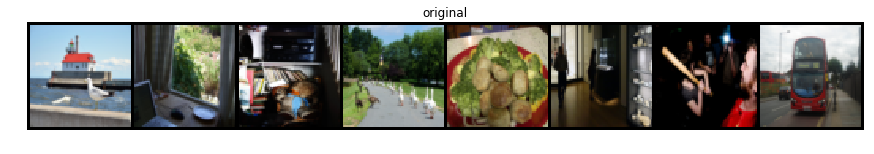

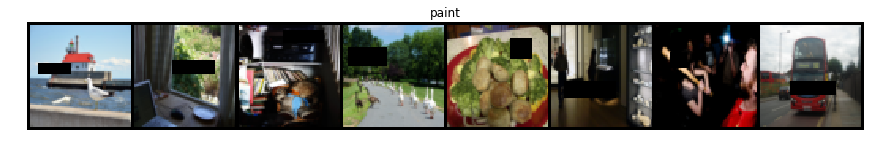

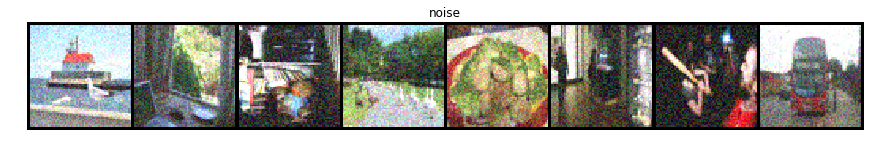

In [6]:
# 画像サンプル
samples = next(iter(test_loader))
show_img(samples, 'original')
print(samples.shape)

mask = torch.stack([make_mask(img_size, samples.shape[1]) for i in range(batch_size)], dim=0)
noise = torch.rand(batch_size,samples.shape[1],img_size[0],img_size[1])

samples_paint = torch.mul(samples, mask) # add mask
show_img(samples_paint, 'paint')

samples_noise = torch.add(samples.cpu(), 0.3*noise) # add noise
show_img(samples_noise, 'noise')

## model

In [7]:
model = Model(in_channels=in_channels, out_channels=out_channels, task_num=task_num).to(device)
model = torch.nn.DataParallel(model)

## train

In [8]:
# loss func and optimizer
# we compute reconstruction after decoder so use Mean Squared Error
# In order to use multi parameters with one optimizer,
# concat parameters after changing into list

parameters = list(model.parameters())
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(parameters, lr=learning_rate)

In [9]:
# train encoder and decoder
# save and load model
if not os.path.exists('model'):
    os.mkdir('model')
    print("directory maked")
    
load_epoch = 0
try:
    param = torch.load('./model/model_{}.pth'.format(load_epoch))
    model.load_state_dict(param)
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass

for i in range(epoch):
    i = i + load_epoch
    for j,images in enumerate(train_loader):
        noise = torch.rand(images.shape)
        images_noise = torch.add(images.cpu(), 0.3*noise).to(device) # add noise
        
        mask = torch.stack([make_mask(img_size, images.shape[1]) for i in range(images.shape[0])], dim=0)
        images_paint = torch.mul(images, mask).to(device) # add mask
        
        images = images.to(device)
        
        optimizer.zero_grad()
        
        output_denoising = model(images_noise, task_id=0)
        output_inpainting = model(images_paint, task_id=1)
        
        loss = loss_func(output_denoising,images) + loss_func(output_inpainting,images)
        loss.backward()
        
        optimizer.step()
        
        if j % 500 == 0:
            print('{}epoch:{}/{},loss:{}'.format(i+1,j,len(train_loader),loss.item()))
        
    if (i+1) % 2 == 0:
        torch.save(model.state_dict(),'./model/model_{}.pth'.format(i+1))


--------model not restored--------

1epoch:0/2587,loss:0.5425204038619995
1epoch:500/2587,loss:0.027585413306951523
1epoch:1000/2587,loss:0.010876024141907692
1epoch:1500/2587,loss:0.012177009135484695
1epoch:2000/2587,loss:0.018226323649287224
1epoch:2500/2587,loss:0.01412108913064003
2epoch:0/2587,loss:0.011148829013109207
2epoch:500/2587,loss:0.013577291741967201
2epoch:1000/2587,loss:0.007528920657932758
2epoch:1500/2587,loss:0.012065512128174305
2epoch:2000/2587,loss:0.011649712920188904
2epoch:2500/2587,loss:0.008592942729592323
3epoch:0/2587,loss:0.007194808684289455
3epoch:500/2587,loss:0.007830371148884296
3epoch:1000/2587,loss:0.014273669570684433
3epoch:1500/2587,loss:0.012199029326438904
3epoch:2000/2587,loss:0.012059004977345467
3epoch:2500/2587,loss:0.011966541409492493
4epoch:0/2587,loss:0.007324607111513615
4epoch:500/2587,loss:0.006950256414711475
4epoch:1000/2587,loss:0.0064267972484230995
4epoch:1500/2587,loss:0.014498777687549591
4epoch:2000/2587,loss:0.00816570967